<a href="https://colab.research.google.com/github/mustafaugur5/VisDrone/blob/master/YoloSahiNoCOCO_HasOwn_mAp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#CLOUD
#Set Accordingly when working in local or in cloud from scratch
INITIALWORK = True
EXISTINGWORK = False
drivePretrainedDirectory = "/content/drive/MyDrive/Yolov8_Train_Results/yolov8m_e25b4p0CS/weights/best.pt"
driveSaveDirectory = "/content/drive/MyDrive/Yolov8_Test_Results" # need to change

In [3]:
!pip install -U torch sahi ultralytics
!pip install pillow pycocotools
!git clone https://github.com/ultralytics/ultralytics.git
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.7/802.7 kB 63.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-ma

In [4]:
# Clone yolov5
import os
if not os.path.exists('yolov5'):
  !git clone https://github.com/ultralytics/yolov5
os.chdir('yolov5')
#%pip install -r requirements.txt # Clone yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16799, done.
remote: Counting objects: 100% (340/340), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 16799 (delta 185), reused 180 (delta 95), pack-reused 16459
Receiving objects: 100% (16799/16799), 15.58 MiB | 27.69 MiB/s, done.
Resolving deltas: 100% (11488/11488), done.


In [5]:
#@title Default imports and definitions
# Default imports and definitions
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np
from utils.general import download, os, Path

path= "../datasets/VisDrone"  # dataset root dir
train= "VisDrone2019-DET-train/images"  # train images (relative to 'path')  6471 images
val= "VisDrone2019-DET-val/images"  # val images (relative to 'path')  548 images
test= "VisDrone2019-DET-test-dev/images"  # test images (optional)  1610 images

In [6]:
#@title vis2Yolo
# Visdrone functions for converting to Yolo complaint form
def visdrone2yolo(dir):
    from PIL import Image
    from tqdm import tqdm

    def convert_box(size, box):
        # Convert VisDrone box to YOLO xywh box
        dw = 1. / size[0]
        dh = 1. / size[1]
        return (box[0] + box[2] / 2) * dw, (box[1] + box[3] / 2) * dh, box[2] * dw, box[3] * dh

    (dir / 'labels').mkdir(parents=True, exist_ok=True)  # make labels directory
    pbar = tqdm((dir / 'annotations').glob('*.txt'), desc=f'Converting {dir}')
    for f in pbar:
        img_size = Image.open((dir / 'images' / f.name).with_suffix('.jpg')).size
        lines = []
        with open(f, 'r') as file:  # read annotation.txt
            for row in [x.split(',') for x in file.read().strip().splitlines()]:
                if row[4] == '0':  # VisDrone 'ignored regions' class 0
                    continue
                cls = int(row[5]) - 1
                box = convert_box(img_size, tuple(map(int, row[:4])))
                lines.append(f"{cls} {' '.join(f'{x:.6f}' for x in box)}\n")
                with open(str(f).replace(os.sep + 'annotations' + os.sep, os.sep + 'labels' + os.sep), 'w') as fl:
                    fl.writelines(lines)  # write label.txt

In [7]:
#@title download dataset
dir = Path(path)  # dataset root dir
if(INITIALWORK):
  urls = ['https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-train.zip',
          'https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-val.zip',
          'https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-test-dev.zip',
          'https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-test-challenge.zip']
  download(urls, dir=dir, curl=True, threads=4)

Unzipping ../datasets/VisDrone/VisDrone2019-DET-val.zip...
Unzipping ../datasets/VisDrone/VisDrone2019-DET-test-dev.zip...
Unzipping ../datasets/VisDrone/VisDrone2019-DET-test-challenge.zip...
Unzipping ../datasets/VisDrone/VisDrone2019-DET-train.zip...


In [8]:
! ls  /content/datasets/VisDrone/VisDrone2019-DET-val/
! ls  /content/datasets/VisDrone/VisDrone2019-DET-test-dev/
! ls  /content/datasets/VisDrone/VisDrone2019-DET-train/

annotations  images
annotations  images
annotations  images


In [9]:
# Ready the next Dataset Labels
! git clone https://github.com/mustafaugur5/VisDrone.git /content/VisDroneModified/
!ls /content/VisDroneModified/

! rm -rf  /content/datasets/VisDrone/VisDrone2019-DET-val/annotations/
! rm -rf  /content/datasets/VisDrone/VisDrone2019-DET-test-dev/annotations/
! rm -rf  /content/datasets/VisDrone/VisDrone2019-DET-train/annotations/

! rm -rf  /content/datasets/VisDrone/VisDrone2019-DET-val/labels/
! rm -rf  /content/datasets/VisDrone/VisDrone2019-DET-test-dev/labels/
! rm -rf  /content/datasets/VisDrone/VisDrone2019-DET-train/labels/

! rm -rf  /content/datasets/VisDrone/VisDrone2019-DET-val/labels.cache
! rm -rf  /content/datasets/VisDrone/VisDrone2019-DET-test-dev/labels.cache
! rm -rf  /content/datasets/VisDrone/VisDrone2019-DET-train/labels.cache


! ls  /content/datasets/VisDrone/VisDrone2019-DET-val/
! ls  /content/datasets/VisDrone/VisDrone2019-DET-test-dev/
! ls  /content/datasets/VisDrone/VisDrone2019-DET-train/

Cloning into '/content/VisDroneModified'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 75 (delta 16), reused 32 (delta 8), pack-reused 35
Receiving objects: 100% (75/75), 59.78 MiB | 15.04 MiB/s, done.
Resolving deltas: 100% (20/20), done.
annotations_plus0C_test.zip    annotations_plus1C_val.zip	 annotations_VisDrone_train_0C.json
annotations_plus0C_train.zip   annotations_plus2C_test.zip	 annotations_VisDrone_val_0C.json
annotations_plus0C_val.zip     annotations_plus2C_train.zip	 convert_yolo_to_coco.py
annotations_plus10C_test.zip   annotations_plus2C_val.zip	 sahi_yolov8_config.json
annotations_plus10C_train.zip  annotations_plus5C_test.zip	 TESTING_lables.zip
annotations_plus10C_val.zip    annotations_plus5C_train.zip	 TESTING.zip
annotations_plus1C_test.zip    annotations_plus5C_val.zip	 vis2coco.py
annotations_plus1C_train.zip   annotations_VisDrone_dev_0C.json  VisDroneSupe

In [10]:
# #################### NEEDS PATH CORRECTING ####################
! cp /content/VisDroneModified/annotations_plus0C_test.zip /content/datasets/VisDrone/VisDrone2019-DET-test-dev/
! cp /content/VisDroneModified/annotations_plus0C_train.zip /content/datasets/VisDrone/VisDrone2019-DET-train/
! cp /content/VisDroneModified/annotations_plus0C_val.zip /content/datasets/VisDrone/VisDrone2019-DET-val/

!unzip /content/datasets/VisDrone/VisDrone2019-DET-val/annotations_plus0C_val.zip -d /content/datasets/VisDrone/VisDrone2019-DET-val/
!unzip /content/datasets/VisDrone/VisDrone2019-DET-test-dev/annotations_plus0C_test.zip -d /content/datasets/VisDrone/VisDrone2019-DET-test-dev/
!unzip /content/datasets/VisDrone/VisDrone2019-DET-train/annotations_plus0C_train.zip -d /content/datasets/VisDrone/VisDrone2019-DET-train/

! rm /content/datasets/VisDrone/VisDrone2019-DET-val/annotations_plus0C_val.zip
! rm /content/datasets/VisDrone/VisDrone2019-DET-test-dev/annotations_plus0C_test.zip
! rm /content/datasets/VisDrone/VisDrone2019-DET-train/annotations_plus0C_train.zip

! mv /content/datasets/VisDrone/VisDrone2019-DET-val/annotations_plus0C_val  /content/datasets/VisDrone/VisDrone2019-DET-val/annotations
! mv /content/datasets/VisDrone/VisDrone2019-DET-test-dev/annotations_plus0C_test  /content/datasets/VisDrone/VisDrone2019-DET-test-dev/annotations
! mv /content/datasets/VisDrone/VisDrone2019-DET-train/annotations_plus0C_train  /content/datasets/VisDrone/VisDrone2019-DET-train/annotations

! ls  /content/datasets/VisDrone/VisDrone2019-DET-val/
! ls  /content/datasets/VisDrone/VisDrone2019-DET-test-dev/
! ls  /content/datasets/VisDrone/VisDrone2019-DET-train/

Streaming output truncated to the last 5000 lines.
  inflating: /content/datasets/VisDrone/VisDrone2019-DET-train/annotations/9999955_00000_d_0000429.txt  
  inflating: /content/datasets/VisDrone/VisDrone2019-DET-train/annotations/9999956_00000_d_0000007.txt  
  inflating: /content/datasets/VisDrone/VisDrone2019-DET-train/annotations/9999956_00000_d_0000011.txt  
  inflating: /content/datasets/VisDrone/VisDrone2019-DET-train/annotations/9999956_00000_d_0000019.txt  
  inflating: /content/datasets/VisDrone/VisDrone2019-DET-train/annotations/9999956_00000_d_0000028.txt  
  inflating: /content/datasets/VisDrone/VisDrone2019-DET-train/annotations/9999956_00000_d_0000043.txt  
  inflating: /content/datasets/VisDrone/VisDrone2019-DET-train/annotations/9999956_00000_d_0000048.txt  
  inflating: /content/datasets/VisDrone/VisDrone2019-DET-train/annotations/9999956_00000_d_0000054.txt  
  inflating: /content/datasets/VisDrone/VisDrone2019-DET-train/annotations/9999956_00000_d_0000061.txt  
  in

In [11]:
! ls  /content/datasets/VisDrone/VisDrone2019-DET-val/
! ls  /content/datasets/VisDrone/VisDrone2019-DET-test-dev/
! ls  /content/datasets/VisDrone/VisDrone2019-DET-train/

annotations  images
annotations  images
annotations  images


In [12]:
#@title Create SuperSet Using Annotation Folder
datasetPaths = {
    "Test" : "/content/datasets/VisDrone/VisDrone2019-DET-test-dev/annotations",
    "Train": "/content/datasets/VisDrone/VisDrone2019-DET-train/annotations",
    "Val"  : "/content/datasets/VisDrone/VisDrone2019-DET-val/annotations",
}

VisDroneObjectEnumStr = {
     "ignored" : 0,
     "pedestrian" : 1,
     "people" : 2,
     "bicycle" : 3,
     "car" : 4,
     "van" : 5,
     "truck" : 6,
     "tricycle" : 7,
     "awning_tricycle" : 8,
     "bus" : 9,
     "motor" : 10,
     "others" : 11,
}

VisDroneObjectEnumSuperSet = {
     "ignored" : 0,
     "pedestrian" : 1,
     "motor" : 2,
     "car" : 3,
     "truck" : 4,
     "others" : 5,
}

VisDroneObjectEnumSuperSetInt = {
     0 : "ignored" ,
     1 : "pedestrian" ,
     2 : "motor" ,
     3 : "car" ,
     4 : "truck" ,
     5 : "others" ,
}

def create_unique_folder_path(base_path):
    if not os.path.exists(base_path):
        return base_path

    counter = 1
    while True:
        new_path = f"{base_path}_{counter}"
        if not os.path.exists(new_path):
            return new_path
        counter += 1

def CreateSuperSet(data_type):
    folder_path = datasetPaths.get(data_type)
    new_folder_path = create_unique_folder_path(os.path.join(os.path.dirname( folder_path ), f"annotations_SuperSet_{data_type}"))
    os.makedirs(new_folder_path)

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".txt"):
            filepath = os.path.join(folder_path, filename)
            new_filepath = os.path.join(new_folder_path, filename)

        with open(filepath, 'r') as file, open(new_filepath, 'w') as new_file:
            for line in file:
                components = line.strip().split(",")
                if len(components) >= 8:
                    x_begin = components[0]
                    y_begin = components[1]
                    obj_width = components[2]
                    obj_height = components[3]
                    score = components[4]
                    class_id = components[5]
                    other_components = components[6:]

                    if(int(class_id) == int(VisDroneObjectEnumStr["pedestrian"]) or int(class_id) == int(VisDroneObjectEnumStr["people"])):
                        class_id = str(VisDroneObjectEnumSuperSet["pedestrian"])
                    elif(int(class_id) == int(VisDroneObjectEnumStr["bicycle"]) or int(class_id) == int(VisDroneObjectEnumStr["tricycle"]) or int(class_id) == int(VisDroneObjectEnumStr["awning_tricycle"]) or int(class_id) == int(VisDroneObjectEnumStr["motor"])):
                        class_id = str(VisDroneObjectEnumSuperSet["motor"])
                    elif(int(class_id) == int(VisDroneObjectEnumStr["car"]) or int(class_id) == int(VisDroneObjectEnumStr["van"])):
                        class_id = str(VisDroneObjectEnumSuperSet["car"])
                    elif(int(class_id) == int(VisDroneObjectEnumStr["truck"]) or int(class_id) == int(VisDroneObjectEnumStr["bus"])):
                        class_id = str(VisDroneObjectEnumSuperSet["truck"])
                    elif(int(class_id) == int(VisDroneObjectEnumStr["others"])):
                        class_id = str(VisDroneObjectEnumSuperSet["others"])

                    new_line = f"{x_begin},{y_begin},{obj_width},{obj_height},{score},{class_id}," + ",".join(other_components) + "\n"
                    new_file.write(new_line)
    return new_folder_path

Train_super_set = CreateSuperSet("Train")
Train_super_set_UpDir = os.path.dirname(Train_super_set)
Test_super_set = CreateSuperSet("Test")
Test_super_set_UpDir = os.path.dirname(Test_super_set)
Val_super_set = CreateSuperSet("Val")
Val_super_set_UpDir = os.path.dirname(Val_super_set)


! ls  /content/datasets/VisDrone/VisDrone2019-DET-val/
! ls  /content/datasets/VisDrone/VisDrone2019-DET-test-dev/
! ls  /content/datasets/VisDrone/VisDrone2019-DET-train/

! rm -rf  /content/datasets/VisDrone/VisDrone2019-DET-val/annotations/
! rm -rf  /content/datasets/VisDrone/VisDrone2019-DET-test-dev/annotations/
! rm -rf  /content/datasets/VisDrone/VisDrone2019-DET-train/annotations/

! mv $Train_super_set $Train_super_set_UpDir"/annotations"
! mv $Test_super_set $Test_super_set_UpDir"/annotations"
! mv $Val_super_set $Val_super_set_UpDir"/annotations"

! ls  /content/datasets/VisDrone/VisDrone2019-DET-val/
! ls  /content/datasets/VisDrone/VisDrone2019-DET-test-dev/
! ls  /content/datasets/VisDrone/VisDrone2019-DET-train/


annotations  annotations_SuperSet_Val  images
annotations  annotations_SuperSet_Test	images
annotations  annotations_SuperSet_Train  images
annotations  images
annotations  images
annotations  images


In [13]:
#Convert
for d in 'VisDrone2019-DET-train', 'VisDrone2019-DET-val', 'VisDrone2019-DET-test-dev':
    visdrone2yolo(dir / d)  # convert VisDrone annotations to YOLO labels

Converting ../datasets/VisDrone/VisDrone2019-DET-train: 6471it [00:25, 256.93it/s]
Converting ../datasets/VisDrone/VisDrone2019-DET-val: 548it [00:02, 207.33it/s]
Converting ../datasets/VisDrone/VisDrone2019-DET-test-dev: 1610it [00:05, 298.03it/s]


In [14]:
os.chdir('..')
!pwd
! mv datasets yolov5/

/content


In [15]:
! mkdir /content/Modelss/
! mkdir /content/sahiRuns
! mkdir /content/sahiRuns/sahi_eval
! mkdir /content/sahiRunsSliced/
! mkdir /content/sahiRunsSliced/sahi_eval

In [16]:
# Get the best model from drive.
! cp $drivePretrainedDirectory /content/Modelss/

In [17]:
# Copy TESTING dataset to Visdrone
! unzip /content/VisDroneModified/TESTING_lables.zip -d /

Archive:  /content/VisDroneModified/TESTING_lables.zip
   creating: /content/yolov5/datasets/VisDrone/TESTING/
   creating: /content/yolov5/datasets/VisDrone/TESTING/annotations/
  inflating: /content/yolov5/datasets/VisDrone/TESTING/annotations/0000006_04050_d_0000010.txt  
  inflating: /content/yolov5/datasets/VisDrone/TESTING/annotations/0000006_04309_d_0000011.txt  
  inflating: /content/yolov5/datasets/VisDrone/TESTING/annotations/0000006_02616_d_0000007.txt  
  inflating: /content/yolov5/datasets/VisDrone/TESTING/annotations/0000006_00159_d_0000001.txt  
  inflating: /content/yolov5/datasets/VisDrone/TESTING/annotations/0000006_03636_d_0000009.txt  
  inflating: /content/yolov5/datasets/VisDrone/TESTING/annotations/0000006_00611_d_0000002.txt  
  inflating: /content/yolov5/datasets/VisDrone/TESTING/annotations/0000006_01659_d_0000004.txt  
  inflating: /content/yolov5/datasets/VisDrone/TESTING/annotations/0000006_01275_d_0000004.txt  
  inflating: /content/yolov5/datasets/VisDron

In [29]:
#@title Metrics for Whole Folder 1-3 (Has Json Saving) Changing Parameters By hand
import os
import json
import numpy as np
from ultralytics import YOLO
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction

m_slice_height=768
m_slice_width=768
m_overlap_height_ratio=0.25
m_overlap_width_ratio=0.25
m_postprocess_match_metric= 'IOU'
m_postprocess_type='GREEDYNMM'

test_type = "TESTING"
test_type = "FULL"
run_yolo = False

def iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    if inter_x_max < inter_x_min or inter_y_max < inter_y_min:
        inter_area = 0
    else:
        inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)

    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = box1_area + box2_area - inter_area
    if union_area == 0:
        return 0
    iou = inter_area / union_area

    return iou

def convert_to_bbox(annotation):
    gt_bboxes = []
    with open(annotation, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if int(parts[5]) == 0:
                continue
            class_id = int(parts[5]) - 1
            x_min, y_min, width, height = map(int, parts[:4])
            x_max = x_min + width
            y_max = y_min + height
            gt_bboxes.append((class_id, x_min, y_min, x_max, y_max))
    return gt_bboxes

def calculate_metrics(gt_bboxes, pred_bboxes, iou_threshold=0.5):
    tp = 0
    fp = 0
    fn = 0

    gt_bboxes_used = [False] * len(gt_bboxes)

    for pred_box in pred_bboxes:
        pred_class, pred_x_min, pred_y_min, pred_x_max, pred_y_max, pred_conf = pred_box
        match_found = False
        for i, gt_box in enumerate(gt_bboxes):
            gt_class, gt_x_min, gt_y_min, gt_x_max, gt_y_max = gt_box
            if gt_class == pred_class:
                iou_score = iou((pred_x_min, pred_y_min, pred_x_max, pred_y_max),
                                (gt_x_min, gt_y_min, gt_x_max, gt_y_max))
                if iou_score >= iou_threshold:
                    if not gt_bboxes_used[i]:
                        tp += 1
                        gt_bboxes_used[i] = True
                        match_found = True
                        break
        if not match_found:
            fp += 1

    for used in gt_bboxes_used:
        if not used:
            fn += 1

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (fn + tp) if (fn + tp) > 0 else 0
    ap = precision * recall  # This is a simplified AP calculation for illustrative purposes

    return precision, recall, ap


def evaluate_folder(image_folder, annotation_folder, yolov8_model_path, iou_threshold=0.5):
    yolo_results_list = []
    sahi_results_list = []

    model = YOLO(yolov8_model_path)
    detection_model = AutoDetectionModel.from_pretrained(
        model_type="yolov8",
        model_path=yolov8_model_path,
        confidence_threshold=0.5,
        device="cuda:0"
    )

    for image_name in os.listdir(image_folder):
        if image_name.endswith(".jpg"):
            image_path = os.path.join(image_folder, image_name)
            annotation_path = os.path.join(annotation_folder, image_name.replace(".jpg", ".txt"))

            # Ground truth bounding boxes
            gt_bboxes = convert_to_bbox(annotation_path)

            if(run_yolo):
              # YOLOv8 predictions
              yolo_results = model.predict(image_path, imgsz=1280, conf=0.5)
              yolo_predictions = []
              for result in yolo_results:
                  for box in result.boxes:
                      x_min, y_min, x_max, y_max = map(float, box.xyxy[0])
                      conf = float(box.conf[0])
                      cls = int(box.cls[0])
                      yolo_predictions.append((cls, x_min, y_min, x_max, y_max, conf))

            # SAHI sliced predictions
            sahi_sliced_result = get_sliced_prediction(
                image_path, detection_model, slice_height=m_slice_height, slice_width=m_slice_width, overlap_height_ratio=m_overlap_height_ratio, overlap_width_ratio=m_overlap_width_ratio, postprocess_match_metric= m_postprocess_match_metric, postprocess_type=m_postprocess_type
            )

            sahi_sliced_predictions = [
                (p.category.id, float(p.bbox.minx), float(p.bbox.miny), float(p.bbox.maxx), float(p.bbox.maxy), float(p.score.value))
                for p in sahi_sliced_result.object_prediction_list
            ]
            if(run_yolo):
              # Calculate metrics for YOLOv8
              yolo_precision, yolo_recall, yolo_ap = calculate_metrics(gt_bboxes, yolo_predictions, iou_threshold)
              yolo_results_list.append({
                  "image": image_name,
                  "predictions": yolo_predictions,
                  "precision": yolo_precision,
                  "recall": yolo_recall,
                  "ap": yolo_ap
              })

            # Calculate metrics for SAHI Sliced
            sahi_sliced_precision, sahi_sliced_recall, sahi_sliced_ap = calculate_metrics(gt_bboxes, sahi_sliced_predictions, iou_threshold)
            sahi_results_list.append({
                "image": image_name,
                "predictions": sahi_sliced_predictions,
                "precision": sahi_sliced_precision,
                "recall": sahi_sliced_recall,
                "ap": sahi_sliced_ap
            })
    if(run_yolo):
      # Save YOLOv8 results to JSON
      with open(f'yolov8_{test_type}_results.json', 'w') as yolo_json_file:
          json.dump(yolo_results_list, yolo_json_file, indent=4)

    # Save SAHI+YOLOv8 results to JSON
    with open(f'sahi_{test_type}_{m_slice_height}_{m_slice_width}_{m_overlap_height_ratio}_{m_overlap_width_ratio}_{m_postprocess_match_metric}_{m_postprocess_type}_results.json', 'w') as sahi_json_file:
        json.dump(sahi_results_list, sahi_json_file, indent=4)

    if(run_yolo):
      avg_yolo_precision = np.mean([res["precision"] for res in yolo_results_list])
      avg_yolo_recall = np.mean([res["recall"] for res in yolo_results_list])
      avg_yolo_map = np.mean([res["ap"] for res in yolo_results_list])

    avg_sahi_sliced_precision = np.mean([res["precision"] for res in sahi_results_list])
    avg_sahi_sliced_recall = np.mean([res["recall"] for res in sahi_results_list])
    avg_sahi_sliced_map = np.mean([res["ap"] for res in sahi_results_list])

    if(run_yolo):
      print(f"YOLOv8 - Precision: {avg_yolo_precision:.4f}, Recall: {avg_yolo_recall:.4f}, mAP@0.5: {avg_yolo_map:.4f}")

    print(f"sahi_{test_type}_{m_slice_height}_{m_slice_width}_{m_overlap_height_ratio}_{m_overlap_width_ratio}_{m_postprocess_match_metric}_{m_postprocess_type}_ Sliced - Precision: {avg_sahi_sliced_precision:.4f}, Recall: {avg_sahi_sliced_recall:.4f}, mAP@0.5: {avg_sahi_sliced_map:.4f}")

if(test_type == "TESTING"):
  image_folder = "/content/yolov5/datasets/VisDrone/TESTING/images"
else:
  image_folder = "/content/yolov5/datasets/VisDrone/VisDrone2019-DET-test-dev/images"

annotation_folder = "/content/yolov5/datasets/VisDrone/VisDrone2019-DET-test-dev/annotations"
yolov8_model_path = "/content/Modelss/best.pt"

evaluate_folder(image_folder, annotation_folder, yolov8_model_path)



Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 3 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 3 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 2 slices.
Performing predictio

In [36]:
#@title Metrics for Whole Folder 1-3 (Has Json Saving) Iterating Over Parameters TESTING
import os
import json
import numpy as np
from ultralytics import YOLO
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction

def iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    if inter_x_max < inter_x_min or inter_y_max < inter_y_min:
        inter_area = 0
    else:
        inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)

    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = box1_area + box2_area - inter_area
    if union_area == 0:
        return 0
    iou = inter_area / union_area

    return iou

def convert_to_bbox(annotation):
    gt_bboxes = []
    with open(annotation, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if int(parts[5]) == 0:
                continue
            class_id = int(parts[5]) - 1
            x_min, y_min, width, height = map(int, parts[:4])
            x_max = x_min + width
            y_max = y_min + height
            gt_bboxes.append((class_id, x_min, y_min, x_max, y_max))
    return gt_bboxes

def calculate_metrics(gt_bboxes, pred_bboxes, iou_threshold=0.5):
    tp = 0
    fp = 0
    fn = 0

    gt_bboxes_used = [False] * len(gt_bboxes)

    for pred_box in pred_bboxes:
        pred_class, pred_x_min, pred_y_min, pred_x_max, pred_y_max, pred_conf = pred_box
        match_found = False
        for i, gt_box in enumerate(gt_bboxes):
            gt_class, gt_x_min, gt_y_min, gt_x_max, gt_y_max = gt_box
            if gt_class == pred_class:
                iou_score = iou((pred_x_min, pred_y_min, pred_x_max, pred_y_max),
                                (gt_x_min, gt_y_min, gt_x_max, gt_y_max))
                if iou_score >= iou_threshold:
                    if not gt_bboxes_used[i]:
                        tp += 1
                        gt_bboxes_used[i] = True
                        match_found = True
                        break
        if not match_found:
            fp += 1

    for used in gt_bboxes_used:
        if not used:
            fn += 1

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (fn + tp) if (fn + tp) > 0 else 0
    ap = precision * recall  # This is a simplified AP calculation for illustrative purposes

    return precision, recall, ap

def evaluate_folder(image_folder, annotation_folder, yolov8_model_path, m_slice_height, m_slice_width, m_overlap_height_ratio, m_overlap_width_ratio, m_postprocess_match_metric, m_postprocess_type, iou_threshold=0.5, run_yolo=False, test_type="FULL"):
    yolo_results_list = []
    sahi_results_list = []

    model = YOLO(yolov8_model_path)
    detection_model = AutoDetectionModel.from_pretrained(
        model_type="yolov8",
        model_path=yolov8_model_path,
        confidence_threshold=0.5,
        device="cuda:0"
    )

    image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
    total_images = len(image_files)

    for idx, image_name in enumerate(image_files):
        print(f"Processing {idx + 1}/{total_images}: {image_name}")
        image_path = os.path.join(image_folder, image_name)
        annotation_path = os.path.join(annotation_folder, image_name.replace(".jpg", ".txt"))

        # Ground truth bounding boxes
        gt_bboxes = convert_to_bbox(annotation_path)

        if(run_yolo):
            # YOLOv8 predictions
            yolo_results = model.predict(image_path, imgsz=1280, conf=0.5)
            yolo_predictions = []
            for result in yolo_results:
                for box in result.boxes:
                    x_min, y_min, x_max, y_max = map(float, box.xyxy[0])
                    conf = float(box.conf[0])
                    cls = int(box.cls[0])
                    yolo_predictions.append((cls, x_min, y_min, x_max, y_max, conf))

        # SAHI sliced predictions
        sahi_sliced_result = get_sliced_prediction(
            image_path, detection_model, slice_height=m_slice_height, slice_width=m_slice_width, overlap_height_ratio=m_overlap_height_ratio, overlap_width_ratio=m_overlap_width_ratio, postprocess_match_metric=m_postprocess_match_metric, postprocess_type=m_postprocess_type
        )

        sahi_sliced_predictions = [
            (p.category.id, float(p.bbox.minx), float(p.bbox.miny), float(p.bbox.maxx), float(p.bbox.maxy), float(p.score.value))
            for p in sahi_sliced_result.object_prediction_list
        ]
        if(run_yolo):
            # Calculate metrics for YOLOv8
            yolo_precision, yolo_recall, yolo_ap = calculate_metrics(gt_bboxes, yolo_predictions, iou_threshold)
            yolo_results_list.append({
                "image": image_name,
                "predictions": yolo_predictions,
                "precision": yolo_precision,
                "recall": yolo_recall,
                "ap": yolo_ap
            })

        # Calculate metrics for SAHI Sliced
        sahi_sliced_precision, sahi_sliced_recall, sahi_sliced_ap = calculate_metrics(gt_bboxes, sahi_sliced_predictions, iou_threshold)
        sahi_results_list.append({
            "image": image_name,
            "predictions": sahi_sliced_predictions,
            "precision": sahi_sliced_precision,
            "recall": sahi_sliced_recall,
            "ap": sahi_sliced_ap
        })

    if(run_yolo):
        # Save YOLOv8 results to JSON
        with open(f'yolov8_{test_type}_results.json', 'w') as yolo_json_file:
            json.dump(yolo_results_list, yolo_json_file, indent=4)

    # Save SAHI+YOLOv8 results to JSON
    with open(f'sahi_{test_type}_{m_slice_height}_{m_slice_width}_{m_overlap_height_ratio}_{m_overlap_width_ratio}_{m_postprocess_match_metric}_{m_postprocess_type}_results.json', 'w') as sahi_json_file:
        json.dump(sahi_results_list, sahi_json_file, indent=4)

    if(run_yolo):
        avg_yolo_precision = np.mean([res["precision"] for res in yolo_results_list])
        avg_yolo_recall = np.mean([res["recall"] for res in yolo_results_list])
        avg_yolo_map = np.mean([res["ap"] for res in yolo_results_list])

    avg_sahi_sliced_precision = np.mean([res["precision"] for res in sahi_results_list])
    avg_sahi_sliced_recall = np.mean([res["recall"] for res in sahi_results_list])
    avg_sahi_sliced_map = np.mean([res["ap"] for res in sahi_results_list])

    if(run_yolo):
        print(f"YOLOv8 - Precision: {avg_yolo_precision:.4f}, Recall: {avg_yolo_recall:.4f}, mAP@0.5: {avg_yolo_map:.4f}")

    result_str = f"sahi_{test_type}_{m_slice_height}_{m_slice_width}_{m_overlap_height_ratio}_{m_overlap_width_ratio}_{m_postprocess_match_metric}_{m_postprocess_type}_ Sliced - Precision: {avg_sahi_sliced_precision:.4f}, Recall: {avg_sahi_sliced_recall:.4f}, mAP@0.5: {avg_sahi_sliced_map:.4f}"
    print(result_str)
    return result_str

# Set your parameters and folders here
image_folder = "/content/yolov5/datasets/VisDrone/TESTING/images"
annotation_folder = "/content/yolov5/datasets/VisDrone/VisDrone2019-DET-test-dev/annotations"
yolov8_model_path = "/content/Modelss/best.pt"
test_type = "TESTING"

slice_heights = [2500, 1024]
slice_widths = [2500, 1024]
overlap_height_ratios = [0.25, 0.3]
overlap_width_ratios = [0.25, 0.3]
postprocess_match_metrics = ['IOU', 'IOS']
postprocess_types = ['GREEDYNMM', 'NMS']

results = []

for m_slice_height in slice_heights:
    for m_slice_width in slice_widths:
        for m_overlap_height_ratio in overlap_height_ratios:
            for m_overlap_width_ratio in overlap_width_ratios:
                for m_postprocess_match_metric in postprocess_match_metrics:
                    for m_postprocess_type in postprocess_types:
                        result_str = evaluate_folder(
                            image_folder, annotation_folder, yolov8_model_path,
                            m_slice_height, m_slice_width, m_overlap_height_ratio,
                            m_overlap_width_ratio, m_postprocess_match_metric,
                            m_postprocess_type, run_yolo=False, test_type=test_type
                        )
                        results.append(result_str)

with open(f'evaluation_results_{test_type}.txt', 'w') as f:
    for result in results:
        f.write(result + "\n")


Processing 1/10: 0000006_01111_d_0000003.jpg
Performing prediction on 1 slices.
Processing 2/10: 0000006_00611_d_0000002.jpg
Performing prediction on 1 slices.
Processing 3/10: 0000006_03636_d_0000009.jpg
Performing prediction on 1 slices.
Processing 4/10: 0000006_01275_d_0000004.jpg
Performing prediction on 1 slices.
Processing 5/10: 0000006_02138_d_0000006.jpg
Performing prediction on 1 slices.
Processing 6/10: 0000006_04050_d_0000010.jpg
Performing prediction on 1 slices.
Processing 7/10: 0000006_02616_d_0000007.jpg
Performing prediction on 1 slices.
Processing 8/10: 0000006_01659_d_0000004.jpg
Performing prediction on 1 slices.
Processing 9/10: 0000006_04309_d_0000011.jpg
Performing prediction on 1 slices.
Processing 10/10: 0000006_00159_d_0000001.jpg
Performing prediction on 1 slices.
sahi_TESTING_2500_2500_0.25_0.25_IOU_GREEDYNMM_ Sliced - Precision: 0.8520, Recall: 0.7138, mAP@0.5: 0.6143
Processing 1/10: 0000006_01111_d_0000003.jpg
Performing prediction on 1 slices.
Processing 

In [ ]:
#@title Metrics for Whole Folder 1-3 (Has Json Saving) Iterating Over Parameters FULL
import os
import json
import numpy as np
from ultralytics import YOLO
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction

def iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    if inter_x_max < inter_x_min or inter_y_max < inter_y_min:
        inter_area = 0
    else:
        inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)

    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = box1_area + box2_area - inter_area
    if union_area == 0:
        return 0
    iou = inter_area / union_area

    return iou

def convert_to_bbox(annotation):
    gt_bboxes = []
    with open(annotation, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if int(parts[5]) == 0:
                continue
            class_id = int(parts[5]) - 1
            x_min, y_min, width, height = map(int, parts[:4])
            x_max = x_min + width
            y_max = y_min + height
            gt_bboxes.append((class_id, x_min, y_min, x_max, y_max))
    return gt_bboxes

def calculate_metrics(gt_bboxes, pred_bboxes, iou_threshold=0.5):
    tp = 0
    fp = 0
    fn = 0

    gt_bboxes_used = [False] * len(gt_bboxes)

    for pred_box in pred_bboxes:
        pred_class, pred_x_min, pred_y_min, pred_x_max, pred_y_max, pred_conf = pred_box
        match_found = False
        for i, gt_box in enumerate(gt_bboxes):
            gt_class, gt_x_min, gt_y_min, gt_x_max, gt_y_max = gt_box
            if gt_class == pred_class:
                iou_score = iou((pred_x_min, pred_y_min, pred_x_max, pred_y_max),
                                (gt_x_min, gt_y_min, gt_x_max, gt_y_max))
                if iou_score >= iou_threshold:
                    if not gt_bboxes_used[i]:
                        tp += 1
                        gt_bboxes_used[i] = True
                        match_found = True
                        break
        if not match_found:
            fp += 1

    for used in gt_bboxes_used:
        if not used:
            fn += 1

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (fn + tp) if (fn + tp) > 0 else 0
    ap = precision * recall  # This is a simplified AP calculation for illustrative purposes

    return precision, recall, ap

def evaluate_folder(image_folder, annotation_folder, yolov8_model_path, m_slice_height, m_slice_width, m_overlap_height_ratio, m_overlap_width_ratio, m_postprocess_match_metric, m_postprocess_type, iou_threshold=0.5, run_yolo=False, test_type="FULL"):
    yolo_results_list = []
    sahi_results_list = []

    model = YOLO(yolov8_model_path)
    detection_model = AutoDetectionModel.from_pretrained(
        model_type="yolov8",
        model_path=yolov8_model_path,
        confidence_threshold=0.5,
        device="cuda:0"
    )

    image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
    total_images = len(image_files)

    for idx, image_name in enumerate(image_files):
        print(f"Processing {idx + 1}/{total_images}: {image_name}")
        image_path = os.path.join(image_folder, image_name)
        annotation_path = os.path.join(annotation_folder, image_name.replace(".jpg", ".txt"))

        # Ground truth bounding boxes
        gt_bboxes = convert_to_bbox(annotation_path)

        if(run_yolo):
            # YOLOv8 predictions
            yolo_results = model.predict(image_path, imgsz=1280, conf=0.5)
            yolo_predictions = []
            for result in yolo_results:
                for box in result.boxes:
                    x_min, y_min, x_max, y_max = map(float, box.xyxy[0])
                    conf = float(box.conf[0])
                    cls = int(box.cls[0])
                    yolo_predictions.append((cls, x_min, y_min, x_max, y_max, conf))

        # SAHI sliced predictions
        sahi_sliced_result = get_sliced_prediction(
            image_path, detection_model, slice_height=m_slice_height, slice_width=m_slice_width, overlap_height_ratio=m_overlap_height_ratio, overlap_width_ratio=m_overlap_width_ratio, postprocess_match_metric=m_postprocess_match_metric, postprocess_type=m_postprocess_type
        )

        sahi_sliced_predictions = [
            (p.category.id, float(p.bbox.minx), float(p.bbox.miny), float(p.bbox.maxx), float(p.bbox.maxy), float(p.score.value))
            for p in sahi_sliced_result.object_prediction_list
        ]
        if(run_yolo):
            # Calculate metrics for YOLOv8
            yolo_precision, yolo_recall, yolo_ap = calculate_metrics(gt_bboxes, yolo_predictions, iou_threshold)
            yolo_results_list.append({
                "image": image_name,
                "predictions": yolo_predictions,
                "precision": yolo_precision,
                "recall": yolo_recall,
                "ap": yolo_ap
            })

        # Calculate metrics for SAHI Sliced
        sahi_sliced_precision, sahi_sliced_recall, sahi_sliced_ap = calculate_metrics(gt_bboxes, sahi_sliced_predictions, iou_threshold)
        sahi_results_list.append({
            "image": image_name,
            "predictions": sahi_sliced_predictions,
            "precision": sahi_sliced_precision,
            "recall": sahi_sliced_recall,
            "ap": sahi_sliced_ap
        })

    if(run_yolo):
        # Save YOLOv8 results to JSON
        with open(f'yolov8_{test_type}_results.json', 'w') as yolo_json_file:
            json.dump(yolo_results_list, yolo_json_file, indent=4)

    # Save SAHI+YOLOv8 results to JSON
    with open(f'sahi_{test_type}_{m_slice_height}_{m_slice_width}_{m_overlap_height_ratio}_{m_overlap_width_ratio}_{m_postprocess_match_metric}_{m_postprocess_type}_results.json', 'w') as sahi_json_file:
        json.dump(sahi_results_list, sahi_json_file, indent=4)

    if(run_yolo):
        avg_yolo_precision = np.mean([res["precision"] for res in yolo_results_list])
        avg_yolo_recall = np.mean([res["recall"] for res in yolo_results_list])
        avg_yolo_map = np.mean([res["ap"] for res in yolo_results_list])

    avg_sahi_sliced_precision = np.mean([res["precision"] for res in sahi_results_list])
    avg_sahi_sliced_recall = np.mean([res["recall"] for res in sahi_results_list])
    avg_sahi_sliced_map = np.mean([res["ap"] for res in sahi_results_list])

    if(run_yolo):
        print(f"YOLOv8 - Precision: {avg_yolo_precision:.4f}, Recall: {avg_yolo_recall:.4f}, mAP@0.5: {avg_yolo_map:.4f}")

    result_str = f"sahi_{test_type}_{m_slice_height}_{m_slice_width}_{m_overlap_height_ratio}_{m_overlap_width_ratio}_{m_postprocess_match_metric}_{m_postprocess_type}_ Sliced - Precision: {avg_sahi_sliced_precision:.4f}, Recall: {avg_sahi_sliced_recall:.4f}, mAP@0.5: {avg_sahi_sliced_map:.4f}"
    print(result_str)
    return result_str

# Set your parameters and folders here
image_folder = "/content/yolov5/datasets/VisDrone/VisDrone2019-DET-test-dev/images"
annotation_folder = "/content/yolov5/datasets/VisDrone/VisDrone2019-DET-test-dev/annotations"
yolov8_model_path = "/content/Modelss/best.pt"
test_type = "FULL"

slice_heights = [2500, 1024]
slice_widths = [2500, 1024]
overlap_height_ratios = [0.25, 0.3]
overlap_width_ratios = [0.25, 0.3]
postprocess_match_metrics = ['IOU', 'IOS']
postprocess_types = ['GREEDYNMM', 'NMS']

results = []

for m_slice_height in slice_heights:
    for m_slice_width in slice_widths:
        for m_overlap_height_ratio in overlap_height_ratios:
            for m_overlap_width_ratio in overlap_width_ratios:
                for m_postprocess_match_metric in postprocess_match_metrics:
                    for m_postprocess_type in postprocess_types:
                        result_str = evaluate_folder(
                            image_folder, annotation_folder, yolov8_model_path,
                            m_slice_height, m_slice_width, m_overlap_height_ratio,
                            m_overlap_width_ratio, m_postprocess_match_metric,
                            m_postprocess_type, run_yolo=False, test_type=test_type
                        )
                        results.append(result_str)

with open(f'evaluation_results_{test_type}.txt', 'w') as f:
    for result in results:
        f.write(result + "\n")


In [31]:
! zip -r jsonsp0CS.zip *.json

  adding: sahi_FULL_1024_1024_0.25_0.25_IOU_GREEDYNMM_results.json (deflated 80%)
  adding: sahi_FULL_2500_2500_0.25_0.25_IOU_GREEDYNMM_results.json (deflated 80%)
  adding: sahi_FULL_768_768_0.25_0.25_IOU_GREEDYNMM_results.json (deflated 80%)
  adding: sahi_TESTING_1024_1024_0.25_0.25_IOU_GREEDYNMM_results.json (deflated 79%)
  adding: sahi_TESTING_2500_2500_0.25_0.25_IOU_GREEDYNMM_results.json (deflated 79%)
  adding: sahi_TESTING_360_360_0.25_0.25_IOS_GREEDYNMM_results.json (deflated 78%)
  adding: sahi_TESTING_360_360_0.25_0.25_IOS_NMS_results.json (deflated 78%)
  adding: sahi_TESTING_360_360_0.25_0.25_IOU_GREEDYNMM_results.json (deflated 79%)
  adding: sahi_TESTING_360_360_0.25_0.25_IOU_NMS_results.json (deflated 79%)
  adding: sahi_TESTING_480_480_0.25_0.25_IOU_GREEDYNMM_results.json (deflated 79%)
  adding: sahi_TESTING_512_512_0.25_0.25_IOU_GREEDYNMM_results.json (deflated 79%)
  adding: yolov8_FULL_results.json (deflated 80%)
  adding: yolov8_TESTING_results.json (deflated 79

In [35]:
! cp jsons0CS.zip /content/drive/MyDrive/Yolov8_Test_Results/

In [37]:
#@title Read results json and draw bounding boxes
import os
import json
import cv2

# Define a distinct color palette for up to 12 classes
COLORS = [
    (255, 0, 0),      # Red
    (0, 255, 0),      # Green
    (0, 0, 255),      # Blue
    (255, 255, 0),    # Cyan
    (255, 0, 255),    # Magenta
    (0, 255, 255),    # Yellow
    (128, 0, 0),      # Maroon
    (0, 128, 0),      # Dark Green
    (0, 0, 128),      # Navy
    (128, 128, 0),    # Olive
    (128, 0, 128),    # Purple
    (0, 128, 128)     # Teal
]

def draw_bounding_boxes(image_folder, results_json, output_folder):
    # Load the results from the JSON file
    with open(results_json, 'r') as f:
        results = json.load(f)

    # Create the output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over the images folder
    for result in results:
        image_name = result["image"]
        image_path = os.path.join(image_folder, image_name)

        # Read the image
        image = cv2.imread(image_path)

        if image is None:
            print(f"Image {image_name} not found.")
            continue

        # Draw bounding boxes on the image
        for bbox in result["predictions"]:
            cls, x_min, y_min, x_max, y_max, conf = bbox
            x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])

            # Select color based on class
            color = COLORS[cls % len(COLORS)]

            # Draw the bounding box
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)

            # Put the class label and confidence score
            label = f"{cls}: {conf:.2f}"
            cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Save the output image
        output_image_path = os.path.join(output_folder, image_name)
        cv2.imwrite(output_image_path, image)

# Example usage
image_folder = "/content/yolov5/datasets/VisDrone/TESTING/images"
# results_json = "yolov8_results.json"  # or "sahi_yolov8_results.json"
results_json = "sahi_yolov8_results.json"  # or "sahi_yolov8_results.json"
output_folder = "/content/outputBBYolov8sahiv4"

draw_bounding_boxes(image_folder, results_json, output_folder)


In [36]:
#@title compare two jsons
import json
import os

def compare_predictions(json_file1, json_file2, output_json):
    # Load the results from both JSON files
    with open(json_file1, 'r') as f1, open(json_file2, 'r') as f2:
        results1 = json.load(f1)
        results2 = json.load(f2)

    # Create a dictionary for quick lookup
    results2_dict = {res["image"]: res for res in results2}

    comparison_results = []

    # Iterate over results1 and compare with results2
    for res1 in results1:
        image_name = res1["image"]
        ap1 = res1["ap"]

        if image_name in results2_dict:
            res2 = results2_dict[image_name]
            ap2 = res2["ap"]

            if ap1 > ap2:
                comparison_result = "first"
            elif ap1 < ap2:
                comparison_result = "second"
            else:
                comparison_result = "Equal"
        else:
            ap2 = "NaN"
            comparison_result = "NaN"

        comparison_results.append({
            "image": image_name,
            "comparison": comparison_result,
            "ap1": ap1,
            "ap2": ap2
        })

    # Also check if there are any images in results2 that are not in results1
    results1_images = {res["image"] for res in results1}
    for res2 in results2:
        if res2["image"] not in results1_images:
            comparison_results.append({
                "image": res2["image"],
                "comparison": "NaN",
                "ap1": "NaN",
                "ap2": res2["ap"]
            })

    # Save the comparison results to the output JSON file
    with open(output_json, 'w') as out_file:
        json.dump(comparison_results, out_file, indent=4)

# Example usage
json_file1 = "yolov8_results.json"
json_file2 = "sahi_yolov8_results.json"
output_json = "comparison_results_Yolov8vsYolov8Sahi_v4.json"

compare_predictions(json_file1, json_file2, output_json)



In [ ]:
#@title Metrics for Whole Folder All 3 methods (NO JSON SAVING)

import os
import json
import numpy as np
from ultralytics import YOLO
from sahi import AutoDetectionModel
from sahi.predict import get_prediction, get_sliced_prediction

def iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    if inter_x_max < inter_x_min or inter_y_max < inter_y_min:
        inter_area = 0
    else:
        inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)

    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = box1_area + box2_area - inter_area
    if union_area == 0:
        return 0
    iou = inter_area / union_area

    return iou

def convert_to_bbox(annotation):
    gt_bboxes = []
    with open(annotation, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if(int(parts[5]) == 0):
              continue
            class_id = int(parts[5]) - 1
            x_min, y_min, width, height = map(int, parts[:4])
            x_max = x_min + width
            y_max = y_min + height
            gt_bboxes.append((class_id, x_min, y_min, x_max, y_max))
    return gt_bboxes

def calculate_metrics(gt_bboxes, pred_bboxes, iou_threshold=0.5):
    tp = 0
    fp = 0
    fn = 0

    gt_bboxes_used = [False] * len(gt_bboxes)

    for pred_box in pred_bboxes:
        pred_class, pred_x_min, pred_y_min, pred_x_max, pred_y_max, pred_conf = pred_box
        match_found = False
        for i, gt_box in enumerate(gt_bboxes):
            gt_class, gt_x_min, gt_y_min, gt_x_max, gt_y_max = gt_box
            if gt_class == pred_class:
                iou_score = iou((pred_x_min, pred_y_min, pred_x_max, pred_y_max),
                                (gt_x_min, gt_y_min, gt_x_max, gt_y_max))
                if iou_score >= iou_threshold:
                    if not gt_bboxes_used[i]:
                        tp += 1
                        gt_bboxes_used[i] = True
                        match_found = True
                        break
        if not match_found:
            fp += 1

    for used in gt_bboxes_used:
        if not used:
            fn += 1

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (fn + tp) if (fn + tp) > 0 else 0
    ap = precision * recall  # This is a simplified AP calculation for illustrative purposes

    return precision, recall, ap


def evaluate_folder(image_folder, annotation_folder, yolov8_model_path, iou_threshold=0.5):
    yolo_precisions = []
    yolo_recalls = []
    yolo_aps = []

    sahi_precisions = []
    sahi_recalls = []
    sahi_aps = []

    sahi_sliced_precisions = []
    sahi_sliced_recalls = []
    sahi_sliced_aps = []

    model = YOLO(yolov8_model_path)
    detection_model = AutoDetectionModel.from_pretrained(
        model_type="yolov8",
        model_path=yolov8_model_path,
        confidence_threshold=0.5,
        device="cuda:0"
    )

    for image_name in os.listdir(image_folder):
        if image_name.endswith(".jpg"):
            image_path = os.path.join(image_folder, image_name)
            annotation_path = os.path.join(annotation_folder, image_name.replace(".jpg", ".txt"))

            # Ground truth bounding boxes
            gt_bboxes = convert_to_bbox(annotation_path)

            # YOLOv8 predictions
            yolo_results = model.predict(image_path, imgsz=1280, conf=0.5)
            yolo_predictions = []
            for result in yolo_results:
                for box in result.boxes:
                    x_min, y_min, x_max, y_max = box.xyxy[0]
                    conf = box.conf[0]
                    cls = int(box.cls[0])
                    yolo_predictions.append((cls, x_min, y_min, x_max, y_max, conf))

            # SAHI predictions
            sahi_result = get_prediction(image_path, detection_model)
            sahi_predictions = [
                (p.category.id, p.bbox.minx, p.bbox.miny, p.bbox.maxx, p.bbox.maxy, p.score.value)
                for p in sahi_result.object_prediction_list
            ]

            # SAHI sliced predictions
            sahi_sliced_result = get_sliced_prediction(
                image_path, detection_model, slice_height=2500, slice_width=2500, overlap_height_ratio=0.2, overlap_width_ratio=0.2
            )
            sahi_sliced_predictions = [
                (p.category.id, p.bbox.minx, p.bbox.miny, p.bbox.maxx, p.bbox.maxy, p.score.value)
                for p in sahi_sliced_result.object_prediction_list
            ]

            # Calculate metrics for YOLOv8
            yolo_precision, yolo_recall, yolo_ap = calculate_metrics(gt_bboxes, yolo_predictions, iou_threshold)
            yolo_precisions.append(yolo_precision)
            yolo_recalls.append(yolo_recall)
            yolo_aps.append(yolo_ap)

            # Calculate metrics for SAHI
            sahi_precision, sahi_recall, sahi_ap = calculate_metrics(gt_bboxes, sahi_predictions, iou_threshold)
            sahi_precisions.append(sahi_precision)
            sahi_recalls.append(sahi_recall)
            sahi_aps.append(sahi_ap)

            # Calculate metrics for SAHI Sliced
            sahi_sliced_precision, sahi_sliced_recall, sahi_sliced_ap = calculate_metrics(gt_bboxes, sahi_sliced_predictions, iou_threshold)
            sahi_sliced_precisions.append(sahi_sliced_precision)
            sahi_sliced_recalls.append(sahi_sliced_recall)
            sahi_sliced_aps.append(sahi_sliced_ap)

    avg_yolo_precision = np.mean(yolo_precisions)
    avg_yolo_recall = np.mean(yolo_recalls)
    avg_yolo_map = np.mean(yolo_aps)

    avg_sahi_precision = np.mean(sahi_precisions)
    avg_sahi_recall = np.mean(sahi_recalls)
    avg_sahi_map = np.mean(sahi_aps)

    avg_sahi_sliced_precision = np.mean(sahi_sliced_precisions)
    avg_sahi_sliced_recall = np.mean(sahi_sliced_recalls)
    avg_sahi_sliced_map = np.mean(sahi_sliced_aps)

    print(f"YOLOv8 - Precision: {avg_yolo_precision:.4f}, Recall: {avg_yolo_recall:.4f}, mAP@0.5: {avg_yolo_map:.4f}")
    print(f"SAHI - Precision: {avg_sahi_precision:.4f}, Recall: {avg_sahi_recall:.4f}, mAP@0.5: {avg_sahi_map:.4f}")
    print(f"SAHI Sliced - Precision: {avg_sahi_sliced_precision:.4f}, Recall: {avg_sahi_sliced_recall:.4f}, mAP@0.5: {avg_sahi_sliced_map:.4f}")

image_folder = "/content/yolov5/datasets/VisDrone/TESTING/images"
annotation_folder = "/content/yolov5/datasets/VisDrone/VisDrone2019-DET-test-dev/annotations"
yolov8_model_path = "/content/Modelss/best.pt"

evaluate_folder(image_folder, annotation_folder, yolov8_model_path)


image 1/1 /content/yolov5/datasets/VisDrone/TESTING/images/0000006_01659_d_0000004.jpg: 736x1280 6 cars, 27 trucks, 51.2ms
Speed: 5.2ms preprocess, 51.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Performing prediction on 1 slices.

image 1/1 /content/yolov5/datasets/VisDrone/TESTING/images/0000006_04309_d_0000011.jpg: 736x1280 1 pedestrian, 13 cars, 8 trucks, 38.0ms
Speed: 5.3ms preprocess, 38.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)
Performing prediction on 1 slices.

image 1/1 /content/yolov5/datasets/VisDrone/TESTING/images/0000006_01111_d_0000003.jpg: 736x1280 2 pedestrians, 3 motors, 12 cars, 2 trucks, 38.8ms
Speed: 5.2ms preprocess, 38.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Performing prediction on 1 slices.

image 1/1 /content/yolov5/datasets/VisDrone/TESTING/images/0000006_00611_d_0000002.jpg: 736x1280 4 pedestrians, 4 motors, 41 cars, 6 trucks, 38.9ms
Speed: 5.3ms preprocess, 38.9ms inference

In [ ]:
#@title Metrics with debug prints. Also has prediction parts WORKS FOR SINGLE IMAGE
import json
import numpy as np
from ultralytics import YOLO
from sahi import AutoDetectionModel
from sahi.predict import get_prediction, get_sliced_prediction
import cv2
import matplotlib.pyplot as plt

# Utility Functions
def save_predictions_to_json(predictions, output_file):
    predictions_list = []
    for pred in predictions:
        pred_dict = {
            "class": int(pred[0]),
            "bbox": [float(pred[1]), float(pred[2]), float(pred[3]), float(pred[4])],
            "confidence": float(pred[5])
        }
        predictions_list.append(pred_dict)
    with open(output_file, 'w') as f:
        json.dump(predictions_list, f, indent=4)

def load_predictions_from_json(json_file):
    with open(json_file, 'r') as f:
        predictions_list = json.load(f)
    predictions = []
    for pred in predictions_list:
        predictions.append((
            pred['class'],
            pred['bbox'][0],
            pred['bbox'][1],
            pred['bbox'][2],
            pred['bbox'][3],
            pred['confidence']
        ))
    return predictions

def parse_visdrone_annotations(annotation_path):
    """Parse VisDrone-style annotation files"""
    with open(annotation_path, 'r') as file:
        lines = file.readlines()
    annotations = []
    for line in lines:
        parts = line.strip().split(',')
        x_min, y_min, width, height = map(int, parts[:4])
        if(int(parts[5]) == 0):
          continue
        class_id = int(parts[5]) - 1
        annotations.append((class_id, x_min, y_min, width, height))
    return annotations

def iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    # Ensure there is an intersection
    if inter_x_max < inter_x_min or inter_y_max < inter_y_min:
        inter_area = 0
    else:
        inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)

    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = box1_area + box2_area - inter_area
    if union_area == 0:
        return 0
    iou = inter_area / union_area

    # print(f"IoU calculation: Box1 {box1}, Box2 {box2}, Inter_area {inter_area}, Union_area {union_area}, IoU {iou}")

    return iou


def calculate_metrics(gt_bboxes, pred_bboxes, iou_threshold=0.5):
    tp = 0
    fp = 0
    fn = 0
    matched_gt_indices = set()

    for pred in pred_bboxes:
        pred_class, pred_x_min, pred_y_min, pred_x_max, pred_y_max, conf = pred
        pred_bbox = (pred_x_min, pred_y_min, pred_x_max, pred_y_max)

        best_iou = 0
        best_gt_index = -1

        for gt_index, gt in enumerate(gt_bboxes):
            gt_class, gt_x_min, gt_y_min, gt_x_max, gt_y_max = gt
            gt_bbox = (gt_x_min, gt_y_min, gt_x_max, gt_y_max)

            if gt_class == pred_class:
                current_iou = iou(gt_bbox, pred_bbox)
                if current_iou > best_iou:
                    best_iou = current_iou
                    best_gt_index = gt_index

        #print(f"Prediction: {pred}, Best IoU: {best_iou}, Best GT Index: {best_gt_index}")

        if best_iou >= iou_threshold and best_gt_index not in matched_gt_indices:
            tp += 1
            matched_gt_indices.add(best_gt_index)
        else:
            fp += 1
    # print(tp)
    # print(fp)
    fn = len(gt_bboxes) - len(matched_gt_indices)

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    return precision, recall

def average_precision(precision, recall):
    precision = np.concatenate([[0], precision, [0]])
    recall = np.concatenate([[0], recall, [1]])

    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])

    indices = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[indices + 1] - recall[indices]) * precision[indices + 1])
    return ap

def mean_average_precision(gt_bboxes, pred_bboxes, iou_threshold=0.5):
    sorted_preds = sorted(pred_bboxes, key=lambda x: x[5], reverse=True)
    precision, recall = [], []

    for threshold in np.linspace(0, 1, 11):
        # print(threshold)
        binarized_preds = [pred for pred in sorted_preds if pred[5] >= threshold]
        prec, rec = calculate_metrics(gt_bboxes, binarized_preds, iou_threshold)
        precision.append(prec)
        recall.append(rec)

    return average_precision(np.array(precision), np.array(recall))

def convert_visdrone_to_bbox(visdrone_annotation):
    class_id, x_min, y_min, width, height = visdrone_annotation
    x_max = x_min + width
    y_max = y_min + height
    return (class_id, x_min, y_min, x_max, y_max)

# Main Evaluation Script 75 objects
test_image_path = "/content/yolov5/datasets/VisDrone/VisDrone2019-DET-test-dev/images/0000006_00159_d_0000001.jpg"
annotation_path = "/content/yolov5/datasets/VisDrone/VisDrone2019-DET-test-dev/annotations/0000006_00159_d_0000001.txt"

# Main Evaluation Script 4 objects
test_image_path = "/content/yolov5/datasets/VisDrone/VisDrone2019-DET-test-dev/images/0000078_02363_d_0000007.jpg"
annotation_path = "/content/yolov5/datasets/VisDrone/VisDrone2019-DET-test-dev/annotations/0000078_02363_d_0000007.txt"

# YOLOv8 Predictions
model = YOLO("/content/Modelss/best.pt")
yolo_results = model.predict(test_image_path, imgsz=1280, conf=0.5)
#yolo_predictions = [(int(box.cls), box.xyxy.tolist()[0], box.xyxy.tolist()[1], box.xyxy.tolist()[2], box.xyxy.tolist()[3], box.conf.item()) for box in yolo_results[0].boxes]
# Convert predictions to a common format
yolo_predictions = []
for result in yolo_results:
    for box in result.boxes:
        x_min, y_min, x_max, y_max = box.xyxy[0]
        conf = box.conf[0]
        cls = int(box.cls[0])
        yolo_predictions.append((cls, x_min, y_min, x_max, y_max, conf))

# Save YOLOv8 predictions
save_predictions_to_json(yolo_predictions, "/content/yolo_predictions.json")

# SAHI Predictions
detection_model = AutoDetectionModel.from_pretrained(model_type="yolov8", model_path="/content/Modelss/best.pt", confidence_threshold=0.5, device="cuda:0")
sahi_result = get_prediction(test_image_path, detection_model)
sahi_predictions = [(int(pred.category.id), pred.bbox.minx, pred.bbox.miny, pred.bbox.maxx, pred.bbox.maxy, pred.score.value) for pred in sahi_result.object_prediction_list]

# Save SAHI predictions
save_predictions_to_json(sahi_predictions, "/content/sahi_predictions.json")

# SAHI Sliced Predictions
sahi_sliced_result = get_sliced_prediction(test_image_path, detection_model, slice_height=2500, slice_width=2500, overlap_height_ratio=0.25, overlap_width_ratio=0.25)
sahi_sliced_predictions = [(int(pred.category.id), pred.bbox.minx, pred.bbox.miny, pred.bbox.maxx, pred.bbox.maxy, pred.score.value) for pred in sahi_sliced_result.object_prediction_list]

# Save SAHI sliced predictions
save_predictions_to_json(sahi_sliced_predictions, "/content/sahi_sliced_predictions.json")

# Parse Ground Truths
gt_bboxes = parse_visdrone_annotations(annotation_path)

# Convert annotations to bbox format
gt_bboxes_bbox_format = [convert_visdrone_to_bbox(annotation) for annotation in gt_bboxes]

# # Print Ground Truths
# print("Ground Truths:")
# for gt in gt_bboxes_bbox_format:
#     print(gt)

# # Print Predictions
# print("YOLOv8 Predictions:")
# for pred in yolo_predictions:
#     print(pred)

# print("SAHI Predictions:")
# for pred in sahi_predictions:
#     print(pred)

# print("SAHI Sliced Predictions:")
# for pred in sahi_sliced_predictions:
#     print(pred)


# Calculate Metrics
precision_yolo, recall_yolo = calculate_metrics(gt_bboxes_bbox_format, yolo_predictions)
mAP50_yolo = mean_average_precision(gt_bboxes_bbox_format, yolo_predictions)
print(f"YOLOv8 - Precision: {precision_yolo:.4f}, Recall: {recall_yolo:.4f}, mAP@0.5: {mAP50_yolo:.4f}")

precision_sahi, recall_sahi = calculate_metrics(gt_bboxes_bbox_format, sahi_predictions)
mAP50_sahi = mean_average_precision(gt_bboxes_bbox_format, sahi_predictions)
print(f"SAHI - Precision: {precision_sahi:.4f}, Recall: {recall_sahi:.4f}, mAP@0.5: {mAP50_sahi:.4f}")

precision_sahi_sliced, recall_sahi_sliced = calculate_metrics(gt_bboxes_bbox_format, sahi_sliced_predictions)
mAP50_sahi_sliced = mean_average_precision(gt_bboxes_bbox_format, sahi_sliced_predictions)
print(f"SAHI Sliced - Precision: {precision_sahi_sliced:.4f}, Recall: {recall_sahi_sliced:.4f}, mAP@0.5: {mAP50_sahi_sliced:.4f}")




image 1/1 /content/yolov5/datasets/VisDrone/VisDrone2019-DET-test-dev/images/0000078_02363_d_0000007.jpg: 736x1280 1 motor, 1 car, 2 trucks, 74.6ms
Speed: 16.7ms preprocess, 74.6ms inference, 833.1ms postprocess per image at shape (1, 3, 736, 1280)
Performing prediction on 1 slices.
YOLOv8 - Precision: 1.0000, Recall: 1.0000, mAP@0.5: 0.5000
SAHI - Precision: 1.0000, Recall: 1.0000, mAP@0.5: 0.5000
SAHI Sliced - Precision: 1.0000, Recall: 1.0000, mAP@0.5: 0.5000


In [ ]:
# Run Validation using CLI.
# !yolo val model=/content/Modelss/best.pt data=/content/ultralytics/ultralytics/cfg/datasets/VisDrone.yaml imgsz=1280 batch=24 device=0 split=test save_json=True # Normal Set
!yolo val model=/content/Modelss/best.pt data=/content/VisDroneModified/VisDroneSuperSet.yaml imgsz=1280 batch=24 device=0 split=test save_json=True # Super Set


Ultralytics YOLOv8.2.51 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25845550 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/yolov5/datasets/VisDrone/TESTING/labels... 10 images, 0 backgrounds, 0 corrupt: 100% 10/10 [00:00<00:00, 687.39it/s]
val: New cache created: /content/yolov5/datasets/VisDrone/TESTING/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:01<00:00,  1.39s/it]
                   all         10        321      0.568      0.644      0.536      0.262
            pedestrian          6         11      0.494      0.455      0.588      0.221
                people          2          9      0.526      0.667      0.641      0.216
               bicycle          1          1       0.24          1      0.249      0.124
                   car          7        145      0.888      0.828      0.898      0.546
                   van          3          8

In [ ]:
TestImages = {
    "1" : "0000006_00159_d_0000001",
    "2": "0000006_02138_d_0000006",
    "3"  : "0000006_00611_d_0000002",
    "4" : "0000006_02616_d_0000007",
    "5": "0000006_01111_d_0000003",
    "6"  : "0000006_03636_d_0000009",
    "7" : "0000006_01275_d_0000004",
    "8": "0000006_04050_d_0000010",
    "9"  : "0000006_01659_d_0000004",
    "10"  : "0000006_04309_d_0000011",
}

save_name = TestImages["1"]
test_image_path = f"/content/yolov5/datasets/VisDrone/TESTING/images/{save_name}.jpg"

In [ ]:
#@title single image prediction yolov8
# YOLOv8 Prediction
# Import necessary libraries
from ultralytics import YOLO

# Load a pretrained YOLOv8 model
model = YOLO("/content/Modelss/best.pt")

# Initialize list to store predictions
all_yolo_predictions = []

# Loop through test images
for key, save_name in TestImages.items():

    test_image_path = f"/content/yolov5/datasets/VisDrone/TESTING/images/{save_name}.jpg"
    # Run inference on the test image with YOLOv8
    results = model.predict(test_image_path, save=True, imgsz=1280, conf=0.5)

    # Process results list
    for result in results:
        boxes = result.boxes  # Boxes object for bounding box outputs
        masks = result.masks  # Masks object for segmentation masks outputs
        keypoints = result.keypoints  # Keypoints object for pose outputs
        probs = result.probs  # Probs object for classification outputs
        obb = result.obb  # Oriented boxes object for OBB outputs
        result.show()  # Display to screen
        result.save(filename=f"result_yolo_{key}.jpg")  # Save to disk with a unique filename

    # Convert predictions to a common format
    yolo_predictions = []
    for result in results:
        for box in result.boxes:
            x_min, y_min, x_max, y_max = box.xyxy[0]
            conf = box.conf[0]
            cls = int(box.cls[0])
            yolo_predictions.append((cls, x_min, y_min, x_max, y_max, conf))

    # Append the predictions for the current image to the main list
    all_yolo_predictions.append((key, yolo_predictions))

# Now, all_yolo_predictions contains the predictions for each image, indexed by the dictionary keys



image 1/1 /content/yolov5/datasets/VisDrone/TESTING/images/0000006_00159_d_0000001.jpg: 736x1280 3 motors, 34 cars, 10 trucks, 77.2ms
Speed: 18.1ms preprocess, 77.2ms inference, 715.7ms postprocess per image at shape (1, 3, 736, 1280)
Results saved to runs/detect/predict

image 1/1 /content/yolov5/datasets/VisDrone/TESTING/images/0000006_02138_d_0000006.jpg: 736x1280 4 cars, 24 trucks, 60.3ms
Speed: 5.6ms preprocess, 60.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
Results saved to runs/detect/predict

image 1/1 /content/yolov5/datasets/VisDrone/TESTING/images/0000006_00611_d_0000002.jpg: 736x1280 4 pedestrians, 4 motors, 41 cars, 6 trucks, 72.8ms
Speed: 5.7ms preprocess, 72.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Results saved to runs/detect/predict

image 1/1 /content/yolov5/datasets/VisDrone/TESTING/images/0000006_02616_d_0000007.jpg: 736x1280 1 car, 23 trucks, 72.8ms
Speed: 5.6ms preprocess, 72.8ms inference, 1.7ms postprocess 

In [ ]:
#@title single image prediction SAHI+Yolov8 No slice
# SAHI predictions
from sahi import AutoDetectionModel
from sahi.predict import get_prediction


# Load the SAHI detection model with YOLOv8
yolov8_model_path = "/content/Modelss/best.pt"
detection_model = AutoDetectionModel.from_pretrained(
    model_type="yolov8",
    model_path=yolov8_model_path,
    confidence_threshold=0.5,
    device="cuda:0",  # or 'cuda:0'
)

# Make predictions using SAHI
sahi_result = get_prediction(
    test_image_path,
    detection_model
)

sahi_result.export_visuals(export_dir="/content/sahiRuns/", file_name=save_name)

# Convert SAHI predictions to a common format
sahi_predictions = []
for obj in sahi_result.object_prediction_list:
    x_min, y_min, x_max, y_max = obj.bbox.to_xyxy()
    conf = obj.score.value
    cls = obj.category.id
    sahi_predictions.append((cls, x_min, y_min, x_max, y_max, conf))


In [ ]:
#@title single image prediciton SAHI+Yolov8 Sliced
# SAHI predictions sliced
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction

# Load the SAHI detection model with YOLOv8
yolov8_model_path = "/content/Modelss/best.pt"
detection_model = AutoDetectionModel.from_pretrained(
    model_type="yolov8",
    model_path=yolov8_model_path,
    confidence_threshold=0.5,
    device="cuda:0",  # or 'cuda:0'
)

# Initialize list to store predictions
all_sahi_sliced_predictions = []

# Loop through test images
for key, save_name in TestImages.items():
    test_image_path = f"/content/yolov5/datasets/VisDrone/TESTING/images/{save_name}.jpg"
    # Make predictions using SAHI
    sahi_sliced_result = get_sliced_prediction(
        test_image_path,
        detection_model,
        slice_height=765,
        slice_width=1360,
        overlap_height_ratio=0.2,
        overlap_width_ratio=0.2,
    )

    # Export visuals with a unique filename
    sahi_sliced_result.export_visuals(export_dir="/content/sahiRunsSliced/", file_name=f"{save_name}_sliced")

    # Convert SAHI sliced predictions to a common format
    sahi_sliced_predictions = []
    for obj in sahi_sliced_result.object_prediction_list:
        x_min, y_min, x_max, y_max = obj.bbox.to_xyxy()
        conf = obj.score.value
        cls = obj.category.id
        sahi_sliced_predictions.append((cls, x_min, y_min, x_max, y_max, conf))

    # Append the predictions for the current image to the main list
    all_sahi_sliced_predictions.append((key, sahi_sliced_predictions))

# Now, all_sahi_sliced_predictions contains the predictions for each image, indexed by the dictionary keys


Performing prediction on 1 slices.
Performing prediction on 1 slices.
Performing prediction on 1 slices.
Performing prediction on 1 slices.
Performing prediction on 1 slices.
Performing prediction on 1 slices.
Performing prediction on 1 slices.
Performing prediction on 1 slices.
Performing prediction on 1 slices.
Performing prediction on 1 slices.


In [ ]:
import os

def parse_yolo_labels(label_path):
    """Parse YOLO-style label files"""
    with open(label_path, 'r') as file:
        lines = file.readlines()
    labels = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        labels.append((class_id, x_center, y_center, width, height))
    return labels

def parse_visdrone_annotations(annotation_path):
    """Parse VisDrone-style annotation files"""
    with open(annotation_path, 'r') as file:
        lines = file.readlines()
    annotations = []
    for line in lines:
        parts = line.strip().split(',')
        x_min, y_min, width, height = map(int, parts[:4])
        class_id = int(parts[5])
        annotations.append((class_id, x_min, y_min, width, height))
    return annotations


In [ ]:
#@title Save and Visualize Json
import json
import cv2
import matplotlib.pyplot as plt

def save_predictions_to_json(predictions, output_file):
    """
    Save predictions to a JSON file.

    Args:
    predictions (list of tuples): List of predictions.
    output_file (str): Output file path.
    """
    predictions_list = []
    for pred in predictions:
        pred_dict = {
            "class": int(pred[0]),
            "bbox": [float(pred[1]), float(pred[2]), float(pred[3]), float(pred[4])],
            "confidence": float(pred[5])
        }
        predictions_list.append(pred_dict)

    with open(output_file, 'w') as f:
        json.dump(predictions_list, f, indent=4)


def load_predictions_from_json(json_file):
    """
    Load predictions from a JSON file.

    Args:
    json_file (str): JSON file path.

    Returns:
    list of tuples: List of predictions.
    """
    with open(json_file, 'r') as f:
        predictions_list = json.load(f)

    predictions = []
    for pred in predictions_list:
        predictions.append((
            pred['class'],
            pred['bbox'][0],
            pred['bbox'][1],
            pred['bbox'][2],
            pred['bbox'][3],
            pred['confidence']
        ))

    return predictions

def visualize_predictions(image_path, predictions):
    """
    Visualize predictions on an image.

    Args:
    image_path (str): Path to the image.
    predictions (list of tuples): List of predictions.
    """
    image = cv2.imread(image_path)
    for pred in predictions:
        cls, x_min, y_min, x_max, y_max, conf = pred
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
        cv2.putText(image, f'{cls} {conf:.2f}', (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()



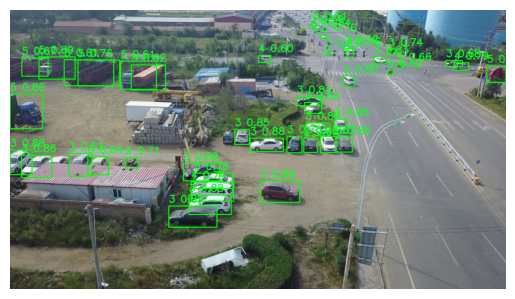

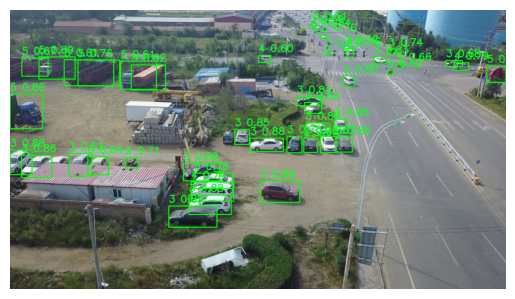

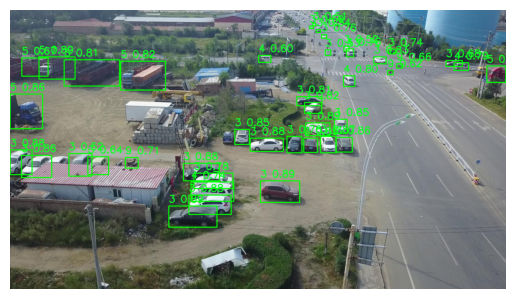

In [ ]:

#@title Save and Visualize Example Calls
# Save YOLOv8 predictions to JSON
save_predictions_to_json(yolo_predictions, "/content/yolo_predictions.json")

# Save SAHI predictions to JSON
save_predictions_to_json(sahi_predictions, "/content/sahi_predictions.json")

# Save SAHI sliced predictions to JSON
save_predictions_to_json(sahi_sliced_predictions, "/content/sahi_sliced_predictions.json")

# Load and visualize YOLOv8 predictions
yolo_predictions = load_predictions_from_json("/content/yolo_predictions.json")
visualize_predictions(test_image_path, yolo_predictions)

# Load and visualize SAHI predictions
sahi_predictions = load_predictions_from_json("/content/sahi_predictions.json")
visualize_predictions(test_image_path, sahi_predictions)

# Load and visualize SAHI sliced predictions
sahi_sliced_predictions = load_predictions_from_json("/content/sahi_sliced_predictions.json")
visualize_predictions(test_image_path, sahi_sliced_predictions)
